In [128]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [129]:
# =============================================================================
# Function to test stationarity 
# =============================================================================

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color = 'blue',label = 'Original')
    plt.plot(rolmean, color = 'green', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel("Data Point")
    plt.ylabel("Total Generation of electricity ($ 1 x 10^{10}$ KWH)")
    plt.show()
    
    return rolmean

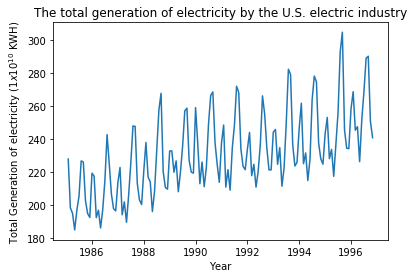

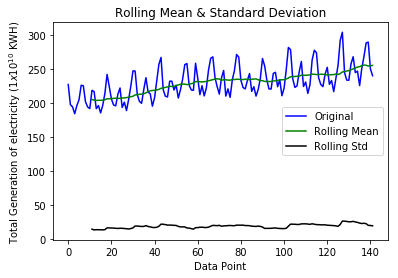

In [130]:
# =============================================================================
# PLOT ORIG DATA
# =============================================================================
val= np.genfromtxt("data.txt", usecols = (1), skip_header= 1, unpack=True)

data = val.flatten()
year = 1985 + (np.arange(1, 143)*1/12)
extended_year = 1985 + (np.arange(1, 200)*1/12)

plt.plot(year, val)
plt.title("The total generation of electricity by the U.S. electric industry") 
plt.xlabel("Year")
plt.ylabel("Total Generation of electricity ($ 1 x 10^{10}$ KWH)")
plt.show()

oring_mean = test_stationarity(val)

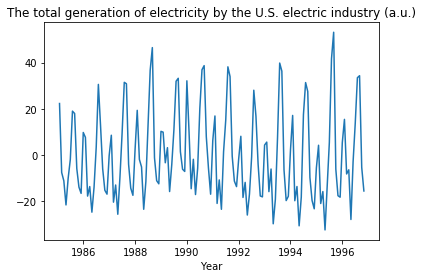

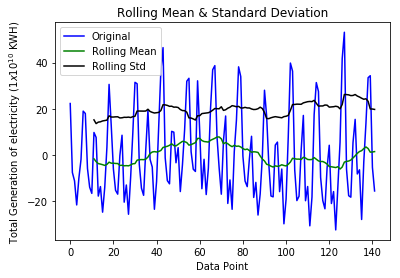

In [131]:
# =============================================================================
# #### Detrend the ORIGINAL Data #####
# =============================================================================

coeff = np.polyfit(year, val,1)
trend = year*coeff[0] + coeff[1]

detrend = val - trend
plt.plot(year, detrend)
plt.title("Detrended Data")
plt.title("The total generation of electricity by the U.S. electric industry (a.u.)") 
plt.xlabel("Year")
plt.show()

mean = test_stationarity(detrend)

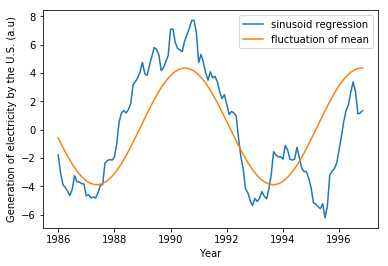

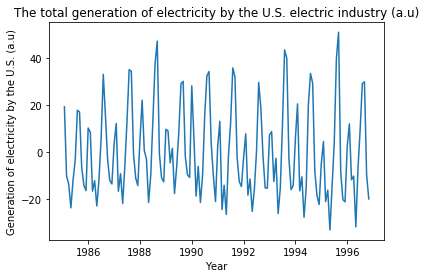

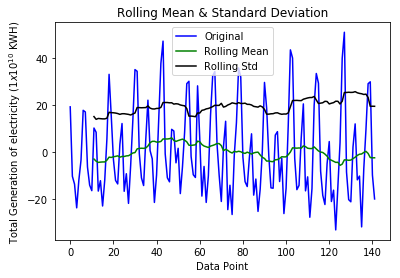

In [132]:
# =============================================================================
# Sinusoid Regression 
# =============================================================================
[popt, pcov] = scipy.optimize.curve_fit(lambda x,a,b,c: a*np.sin(b*x) + c, year[11:], mean[11:])
a = popt[0]
b = popt[1]
c = popt[2]


plt.plot(year[11:], mean[11:], label = 'sinusoid regression')
plt.plot(year[11:],a*np.sin(b*year[11:])+c, label = 'fluctuation of mean')
plt.xlabel("Year")
plt.ylabel("Generation of electricity by the U.S. (a.u)") 
plt.legend()
plt.show()

# =============================================================================
# Detrend Sinusoid
# =============================================================================
sinusoid_trend = a*np.sin(b*year)+c
super_clean = detrend - sinusoid_trend

plt.plot(year, super_clean)
plt.title("The total generation of electricity by the U.S. electric industry (a.u)") 
plt.ylabel("Generation of electricity by the U.S. (a.u)") 
plt.xlabel("Year")
plt.show()
super_test = test_stationarity(super_clean)

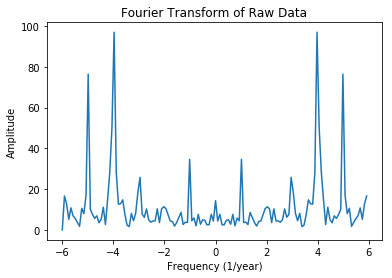

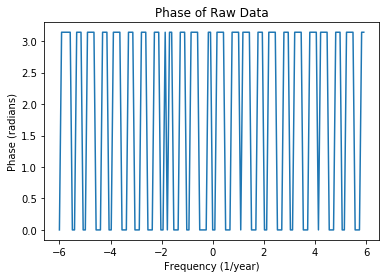

In [133]:
# =============================================================================
# ### FOURIER TRANSFORM OF ORIGINAL DATA ############
# =============================================================================
dt = year[1]-year[0]
transform = np.fft.fft(np.fft.fftshift(super_clean))*dt
angles = np.angle(super_clean, deg = False)
freq = np.fft.fftshift(np.fft.fftfreq(len(transform), dt))


plt.plot(freq, abs(transform))
plt.title("Fourier Transform of Raw Data")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Amplitude")
plt.show()

plt.plot(freq, angles)
plt.title("Phase of Raw Data")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Phase (radians)")
plt.show()

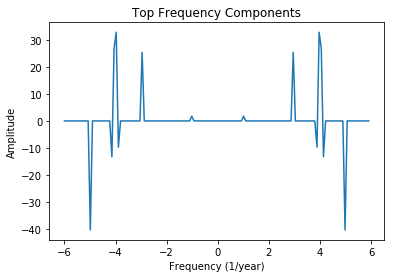

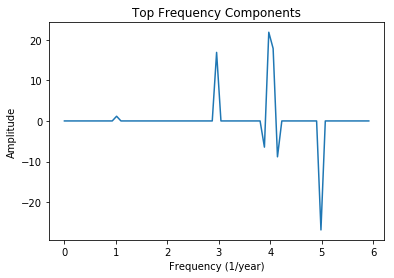

In [134]:
# =============================================================================
# ### CLEANING FT  and showing only positive frequencies 
# =============================================================================

pos_transform = abs(transform)

for i in range(len(pos_transform)):
    if pos_transform[i] < 22:
        transform[i] = 0 
plt.plot(freq, transform)
plt.title("Top Frequency Components")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Amplitude")
plt.show()

pos_freq_index = freq >= 0
pos_freq = freq[pos_freq_index]
pos_angles = angles[pos_freq_index]
pos_freq_transform = transform[pos_freq_index]/1.5

plt.plot(pos_freq, pos_freq_transform)
plt.title("Top Frequency Components")
plt.xlabel("Frequency (1/year)")
plt.ylabel("Amplitude")
plt.show()

In [135]:
# =============================================================================
# ### Reconstructing Data
# =============================================================================
[index, peak]= scipy.signal.find_peaks(abs(pos_freq_transform))

def prediction(time, FFT, freq, FFT_angles, index):
    prediction = np.zeros(len(time))
    omega = 2*np.pi*freq
    for i in range(len(time)):
        t= time[i]
        prediction[i] = sum(FFT[index]*np.cos(omega[index]*t)-1j*FFT[index]*np.sin(omega[index]*t+FFT_angles[index]))
    return prediction 
     

C:\Users\denis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


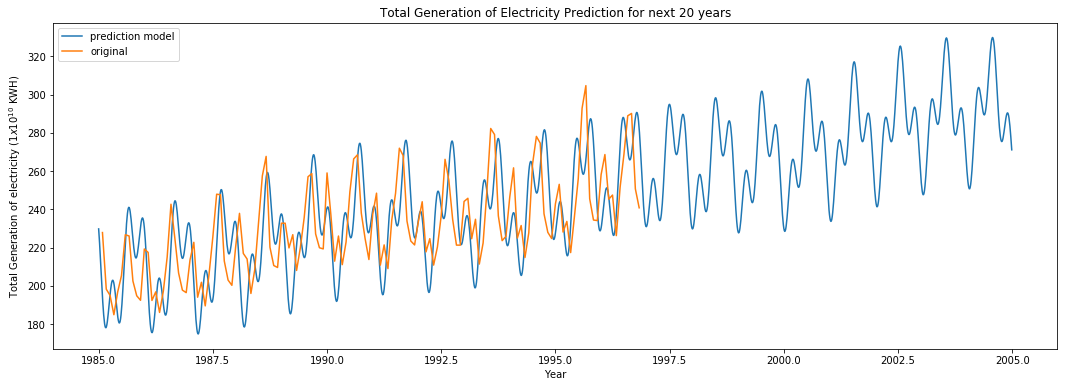

In [136]:
   
# =============================================================================
# ALL DETRENDED PLOTS + Prediction 
# =============================================================================
    
plt.figure(1,figsize=(18,6))

extended_year = 1985 + (np.arange(0, 20, 0.01))

x = extended_year
y = prediction(x, pos_freq_transform, pos_freq,pos_angles,index[:2])
extended_trend = extended_year*coeff[0] + coeff[1]
extended_sinusoid = a*np.sin(b*extended_year)+c

plt.plot(x,y + extended_trend+extended_sinusoid, label = "prediction model")
plt.plot(year, val,  label = "original")
plt.xlabel("Year")
plt.ylabel("Total Generation of electricity ($ 1 x 10^{10}$ KWH)")
plt.title ("Total Generation of Electricity Prediction for next 20 years")
plt.legend()
plt.show()